In [2]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn

import os
import numpy as np
import h5py


Populating the interactive namespace from numpy and matplotlib


## overall results

In [24]:
savedirs = {
    'exactM2': '/scratch/jmj418/theanomodels/experiments/mnist_ssl_vae/006_multiple_seeds_ExactM2-mnist/VAE_lr5_00e-04_qh300_ph200_ds50_pl4_pzl0_ql4_zl2_al2_hzl0_maxout_adam_bs100_idrp0_25_lbdrp0_hxdrp0_l2_rv0_10___gn2_50_aKL1_00_aCW50000_BN_sBNs_b0-0_20_sh1_00_cw128_00_mbw0_mbwxy0_kllg1_00-uid',
    'approxM2': '/scratch/jmj418/theanomodels/experiments/mnist_ssl_vae/006_multiple_seeds_ApproxM2-mnist/VAE_lr5_00e-04_qh300_ph200_ds50_pl4_pzl0_ql4_zl2_al2_hzl0_maxout_adam_bs100_idrp0_25_lbdrp0_hxdrp0_l2_rv0_10___gn2_50_aKL1_00_aCW50000_BN_sBNs_b0-0_20_sh1_00_cw128_00_mbw0_mbwxy0_kllg1_00-uid',
    'Dirichlet_negKL': '/scratch/jmj418/theanomodels/experiments/mnist_ssl_vae/006_multiple_seeds_Dirichlet-mnist/VAE_lr5_00e-04_qh300_ph200_ds50_pl4_pzl0_ql4_zl2_al2_hzl0_maxout_adam_bs100_idrp0_25_lbdrp0_hxdrp0_l2_rv0_10___gn2_50_aKL1_00_aCW50000_nKL_BN_sBNs_b0-0_20_sh1_00_cw128_00_mbw0_mbwxy0_kllg1_00-uid',
    'Dirichlet': '/scratch/jmj418/theanomodels/experiments/mnist_ssl_vae/006_multiple_seeds_Dirichlet-mnist/VAE_lr5_00e-04_qh300_ph200_ds50_pl4_pzl0_ql4_zl2_al2_hzl0_maxout_adam_bs100_idrp0_25_lbdrp0_hxdrp0_l2_rv0_10___gn2_50_aKL1_00_aCW50000_BN_sBNs_b0-0_20_sh1_00_cw128_00_mbw0_mbwxy0_kllg1_00-uid',
    'LogisticNormal': '/scratch/jmj418/theanomodels/experiments/mnist_ssl_vae/006_multiple_seeds_LogisticNormal-mnist/VAE_lr5_00e-04_qh300_ph200_ds50_pl4_pzl0_ql4_zl2_al2_hzl0_maxout_adam_bs100_idrp0_25_lbdrp0_hxdrp0_l2_rv0_10___gn2_50_aKL1_00_aCW50000_BN_sBNs_b0-0_20_sh1_00_cw128_00_mbw0_mbwxy0_kllg1_00-uid',
    'Dirichlet_negKL_anneal_beta': '/scratch/jmj418/theanomodels/experiments/mnist_ssl_vae/006_multiple_seeds_Dirichlet_anneal_beta-mnist/VAE_lr5_00e-04_qh300_ph200_ds50_pl4_pzl0_ql4_zl2_al2_hzl0_maxout_adam_bs100_idrp0_25_lbdrp0_hxdrp0_l2_rv0_10___gn2_50_aKL1_00_aCW50000_nKL_BN_sBNs_b0-0_20_fb5_00e-03_aBP50000_00_sh1_00_cw128_00_mbw0_mbwxy0_kllg1_00-uid',
    }


In [25]:
def loadDataHDF5(data):
    if isinstance(data,h5py.File) or isinstance(data,h5py.Group):
        return {k:loadDataHDF5(v) for k,v in data.iteritems()}
    elif isinstance(data,h5py.Dataset):
        return data.value
    else:
        print 'unhandled datatype: %s' % type(data)

def loadHDF5(filepath):
    with h5py.File(filepath,'r') as f:
        return loadDataHDF5(f)

In [26]:
def loadresults(folderpath):
    myresults = []
    for d in os.listdir(folderpath):
        if 'seed' in d:
            myresults.append(loadHDF5(os.path.join(folderpath,d,'final.h5')))
    return myresults

In [27]:
keylist = ['accuracy','bound','epochs','cost']
def parse_result_dict(r1,r2):
    for k,v in r1.iteritems():
        #print k
        if isinstance(v,dict):
            if k not in r2:
                r2[k] = parse_result_dict(v,{})
            else:
                r2[k] = parse_result_dict(v,r2[k])
        else:
            if k in keylist:
                if k == 'epochs':
                    r2[k] = v.squeeze()  
                elif k in r2:
                    r2[k] = np.concatenate((r2[k],np.expand_dims(v,axis=0)),axis=0)
                else:
                    r2[k] = np.expand_dims(v,axis=0)
    return r2
    

def concatenate_results(result):
    assert isinstance(result,list), 'expected list'
    concresults = {}
    for r in result:
        concresults = parse_result_dict(r,concresults)
    return concresults
    
    

In [28]:
results = {}
for k,v in savedirs.iteritems():
    results[k] = concatenate_results(loadresults(v))

In [42]:
def reshape(x,batch_size=100):
    y = []
    n = len(x)/batch_size
    for i in range(n):
        y.append(x[batch_size*i:batch_size*(i+1)].reshape(1,batch_size,-1))
    y = np.vstack(y)
    return y

def plotPercentiles(x=None,y=None,color='b',areacolor='b',alpha=0.2,label=None,linewidth=1.,func=max):
    if y==None:
        xvals = None
        yvals = x
    else:
        xvals = x
        yvals = y
    p05_norm = np.percentile(yvals,5,axis=1)
    p10_norm = np.percentile(yvals,10,axis=1)
    p25_norm = np.percentile(yvals,25,axis=1)
    p50_norm = np.percentile(yvals,50,axis=1)
    p75_norm = np.percentile(yvals,75,axis=1)
    p90_norm = np.percentile(yvals,90,axis=1)
    p95_norm = np.percentile(yvals,95,axis=1)
    means = yvals.mean(axis=1)
    
    if xvals is None:
        xvals = np.arange(len(p50_norm))
    label = '%0.2f %s' % (func(means),label)
    if color != None:
        plt.plot(xvals,means,color=color,label=label,linewidth=linewidth)
    else:
        plt.plot(xvals,p50_norm,label=label,linewidth=linewidth)
    #plt.fill_between(xvals,p05_norm,p95_norm,color=areacolor,alpha=alpha)
    plt.fill_between(xvals,p10_norm,p90_norm,color=areacolor,alpha=alpha)
    #plt.fill_between(xvals,p25_norm,p75_norm,color=areacolor,alpha=alpha)


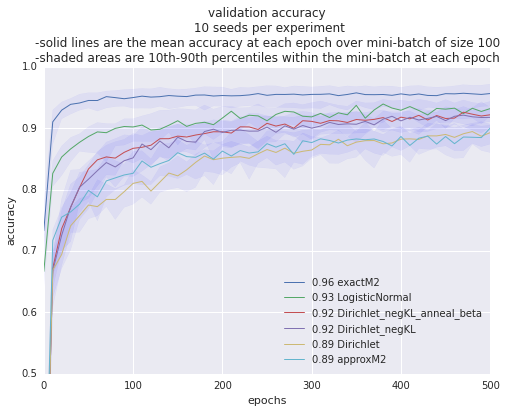

In [46]:
#plt.cm.Gree
color = iter(plt.cm.Greens(np.linspace(0,1,len(results))))
accuracies = {k:np.squeeze(v['valid']['accuracy']) for k,v in results.iteritems()}
for k,v in sorted(accuracies.iteritems(),key=lambda x:x[1][:,-1].mean(),reverse=True):
    epochs = results[k]['valid']['epochs']
    plotPercentiles(epochs,v.T,label=k,color=None,alpha=0.05)
plt.legend(loc='lower right')
plt.ylim(0.5,1)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.title('validation accuracy\n 10 seeds per experiment\n-solid lines are the mean accuracy at each epoch over mini-batch of size 100\n-shaded areas are 10th-90th percentiles within the mini-batch at each epoch')

In [36]:
v['valid']['accuracy'].shape

(10, 51, 1)

(250, 400)

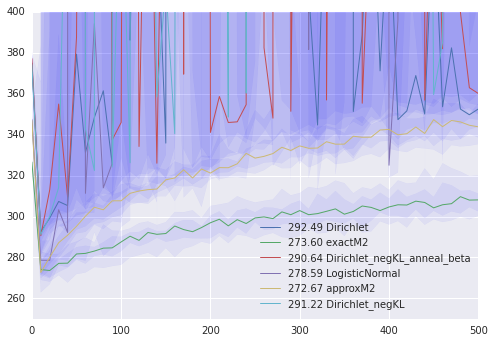

In [31]:
#plt.cm.Gree
color = iter(plt.cm.Greens(np.linspace(0,1,len(results))))
for k,v in results.iteritems():
    plotPercentiles(v['valid']['epochs'],v['valid']['bound'].reshape(v['valid']['accuracy'].shape[0],-1).T,label=k,color=None,alpha=0.05,func=min)
plt.legend(loc='lower right')
plt.ylim(250,400)

In [32]:
def plotExperiment(results,
                   title = '',
                   keys = ['cost','bound','accuracy'],
                   funcs = [min,min,max],
                   yscales = ['linear','linear','linear'],
                   ylims = [(100,600),(100,600),(0.5,1)],
                   locs = ['upper right','upper right','lower right'],
                   label_prefix=None
                   ):
    plt.figure(1,figsize=(18,4))
    for i,(key,f,yscale,ylim,loc) in enumerate(zip(keys,funcs,yscales,ylims,locs)):
        #print i,key
        plt.subplot(1,3,i+1)
        label=label_prefix
        plotPercentiles(results['epochs'],results[key].reshape(10,-1).T,label=label,color=None,alpha=0.05,func=f)
        #plt.plot(results['epochs'],results[key],label=label)
        plt.legend(loc=loc)
        plt.yscale(yscale)
        plt.title('%s %s' % (title,key))
        if ylim is not None:
            plt.ylim(ylim)

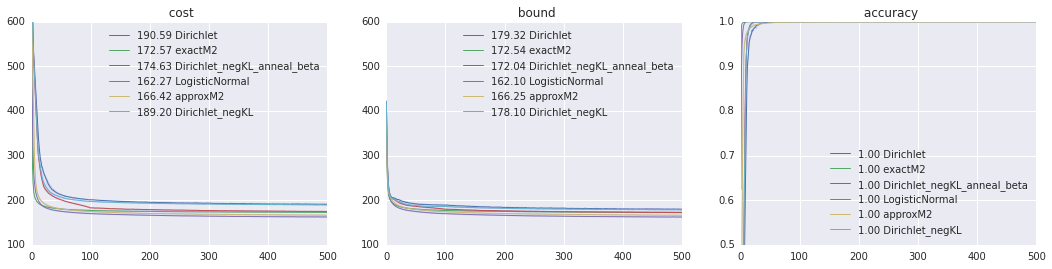

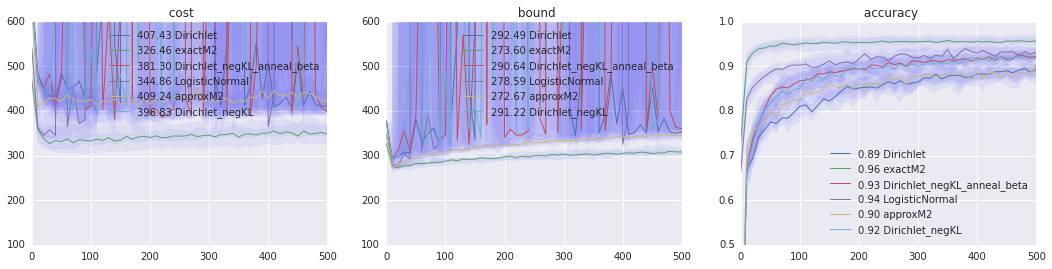

In [33]:
for k,v in results.iteritems():
    plotExperiment(v['train'],label_prefix=k)
plt.show()
for k,v in results.iteritems():
    plotExperiment(v['valid'],label_prefix=k)
plt.show()

In [34]:
results = {k:loadHDF5(filepath) for k,filepath in filepaths.iteritems()}
for k in results.keys():
    print k
    print results[k].keys()
    for kk in results[k].keys():
        pass
        #print results[k][kk].keys()

NameError: name 'filepaths' is not defined

In [ ]:
for k,r in results.iteritems():
    plotExperiment(r['train'],'train',label_prefix=k)
plt.show()
for k,r in results.iteritems():
    plotExperiment(r['valid'],'valid',label_prefix=k)
plt.show()

In [ ]:
modelkey = 'exactM2_BN_pl4ql4'
train = results[modelkey]['train']
valid = results[modelkey]['valid']

In [ ]:
plt.figure(1,figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train['annealKL']*100,label='annealKL')
plt.title('annealKL')
plt.subplot(1,2,2)
plt.plot(train['annealCW']*100,label='annealCW')
plt.title('annealCW')

In [215]:
sorted(train.keys())

[u'KL_L',
 u'KL_U',
 u'KL_Y_U',
 u'KL_Z_L',
 u'KL_Z_U',
 u'L-q_Z_0_BN_running_mean',
 u'L-q_Z_0_BN_running_var',
 u'L-q_Z_1_BN_running_mean',
 u'L-q_Z_1_BN_running_var',
 u'L-q_h(x)_0_BN_running_mean',
 u'L-q_h(x)_0_BN_running_var',
 u'L-q_h(x)_1_BN_running_mean',
 u'L-q_h(x)_1_BN_running_var',
 u'L-q_h(x)_2_BN_running_mean',
 u'L-q_h(x)_2_BN_running_var',
 u'L-q_h(x)_3_BN_running_mean',
 u'L-q_h(x)_3_BN_running_var',
 u'L-q_logbeta_0_BN_running_mean',
 u'L-q_logbeta_0_BN_running_var',
 u'L-q_logbeta_1_BN_running_mean',
 u'L-q_logbeta_1_BN_running_var',
 u'NLL_L',
 u'NLL_U',
 u'U-q_Z_0_BN_running_mean',
 u'U-q_Z_0_BN_running_var',
 u'U-q_Z_1_BN_running_mean',
 u'U-q_Z_1_BN_running_var',
 u'U-q_h(x)_0_BN_running_mean',
 u'U-q_h(x)_0_BN_running_var',
 u'U-q_h(x)_1_BN_running_mean',
 u'U-q_h(x)_1_BN_running_var',
 u'U-q_h(x)_2_BN_running_mean',
 u'U-q_h(x)_2_BN_running_var',
 u'U-q_h(x)_3_BN_running_mean',
 u'U-q_h(x)_3_BN_running_var',
 u'U-q_logbeta_0_BN_running_mean',
 u'U-q_logbeta_0_

In [216]:
train_BNrunningstats = {k:v for k,v in train.iteritems() if 'running' in k}
sorted(train_BNrunningstats.keys())

[u'L-q_Z_0_BN_running_mean',
 u'L-q_Z_0_BN_running_var',
 u'L-q_Z_1_BN_running_mean',
 u'L-q_Z_1_BN_running_var',
 u'L-q_h(x)_0_BN_running_mean',
 u'L-q_h(x)_0_BN_running_var',
 u'L-q_h(x)_1_BN_running_mean',
 u'L-q_h(x)_1_BN_running_var',
 u'L-q_h(x)_2_BN_running_mean',
 u'L-q_h(x)_2_BN_running_var',
 u'L-q_h(x)_3_BN_running_mean',
 u'L-q_h(x)_3_BN_running_var',
 u'L-q_logbeta_0_BN_running_mean',
 u'L-q_logbeta_0_BN_running_var',
 u'L-q_logbeta_1_BN_running_mean',
 u'L-q_logbeta_1_BN_running_var',
 u'U-q_Z_0_BN_running_mean',
 u'U-q_Z_0_BN_running_var',
 u'U-q_Z_1_BN_running_mean',
 u'U-q_Z_1_BN_running_var',
 u'U-q_h(x)_0_BN_running_mean',
 u'U-q_h(x)_0_BN_running_var',
 u'U-q_h(x)_1_BN_running_mean',
 u'U-q_h(x)_1_BN_running_var',
 u'U-q_h(x)_2_BN_running_mean',
 u'U-q_h(x)_2_BN_running_var',
 u'U-q_h(x)_3_BN_running_mean',
 u'U-q_h(x)_3_BN_running_var',
 u'U-q_logbeta_0_BN_running_mean',
 u'U-q_logbeta_0_BN_running_var',
 u'U-q_logbeta_1_BN_running_mean',
 u'U-q_logbeta_1_BN_runnin

In [217]:
prefixes = ['q(y|x)','L','U']
d = {p:{} for p in prefixes}
for k,v in train_BNrunningstats.iteritems():
    for p in prefixes:
        if k[:len(p)]==p:
            d[p][k[len(p)+1:]] = v
            
d2 = set(k for k in d[p].keys() for p in d.keys())
d2 = {k:{p:d[p][k] for p in d.keys() if k in d[p].keys()} for k in d2 }

(0, 4)

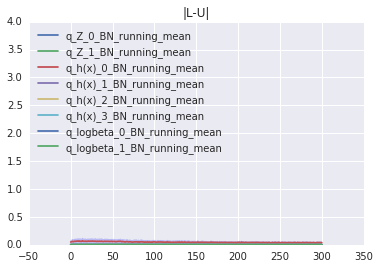

In [218]:
#means
for k,v in sorted(d2.iteritems(),key=lambda x:x[0]):
    if 'mean' in k:
        U = v['U']
        L = v['L']
        diff = np.abs(L-U)
        avgdiff = diff.mean(axis=1)
        p10diff = np.percentile(diff,20,axis=1)
        p90diff = np.percentile(diff,80,axis=1)
        plt.plot(avgdiff,label=k)
        plt.fill_between(np.arange(len(avgdiff)),p10diff,p90diff,color='b',alpha=0.2)
plt.legend(loc='upper left')
plt.title('|L-U|')
plt.ylim(0,4)

(0, 5)

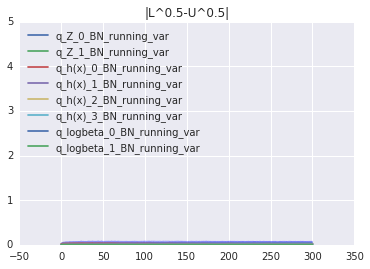

In [219]:
#means
for k,v in sorted(d2.iteritems(),key=lambda x:x[0]):
    if 'var' in k:
        U = v['U']
        L = v['L']
        diff = np.abs(L**0.5-U**0.5)
        avgdiff = diff.mean(axis=1)
        p10diff = np.percentile(diff,10,axis=1)
        p90diff = np.percentile(diff,90,axis=1)
        plt.plot(avgdiff,label=k)
        plt.fill_between(np.arange(len(avgdiff)),p10diff,p90diff,color='b',alpha=0.2)
#plt.yscale('log')
plt.legend(loc='upper left')
plt.title('|L^0.5-U^0.5|')
plt.ylim(0,5)

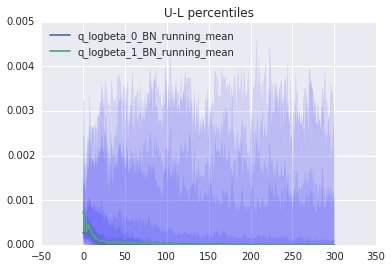

In [220]:
#means
for k,v in sorted(d2.iteritems(),key=lambda x:x[0]):
    if 'running_mean' in k and 'q_logbeta' in k:
        U = v['U']
        L = v['L']
        diff = np.abs(U-L)
        mediandiff = np.percentile(diff,50,axis=1)
        p05diff = np.percentile(diff,5,axis=1)
        p10diff = np.percentile(diff,10,axis=1)
        p25diff = np.percentile(diff,25,axis=1)
        p40diff = np.percentile(diff,40,axis=1)
        p60diff = np.percentile(diff,60,axis=1)
        p75diff = np.percentile(diff,75,axis=1)
        p90diff = np.percentile(diff,90,axis=1)
        p95diff = np.percentile(diff,95,axis=1)
        plt.plot(mediandiff,label=k)
        plt.fill_between(np.arange(len(avgdiff)),p05diff,p95diff,color='b',alpha=0.1)
        plt.fill_between(np.arange(len(avgdiff)),p10diff,p90diff,color='b',alpha=0.1)
        plt.fill_between(np.arange(len(avgdiff)),p25diff,p75diff,color='b',alpha=0.1)
        plt.fill_between(np.arange(len(avgdiff)),p40diff,p60diff,color='b',alpha=0.1)
#plt.yscale('log')
plt.legend(loc='upper left')
plt.title('U-L percentiles')

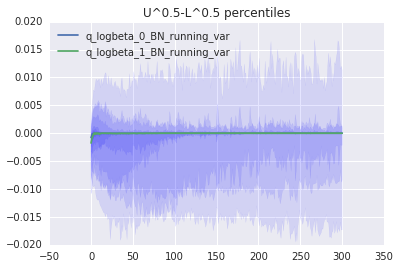

In [221]:
#means
for k,v in sorted(d2.iteritems(),key=lambda x:x[0]):
    if 'running_var' in k and 'q_logbeta' in k:
        U = v['U']
        L = v['L']
        diff = U**0.5-L**0.5
        mediandiff = np.percentile(diff,50,axis=1)
        p05diff = np.percentile(diff,5,axis=1)
        p10diff = np.percentile(diff,10,axis=1)
        p25diff = np.percentile(diff,25,axis=1)
        p40diff = np.percentile(diff,40,axis=1)
        p60diff = np.percentile(diff,60,axis=1)
        p75diff = np.percentile(diff,75,axis=1)
        p90diff = np.percentile(diff,90,axis=1)
        p95diff = np.percentile(diff,95,axis=1)
        plt.plot(mediandiff,label=k)
        plt.fill_between(np.arange(len(avgdiff)),p05diff,p95diff,color='b',alpha=0.1)
        plt.fill_between(np.arange(len(avgdiff)),p10diff,p90diff,color='b',alpha=0.1)
        plt.fill_between(np.arange(len(avgdiff)),p25diff,p75diff,color='b',alpha=0.1)
        plt.fill_between(np.arange(len(avgdiff)),p40diff,p60diff,color='b',alpha=0.1)
#plt.yscale('log')
plt.legend(loc='upper left')
plt.title('U^0.5-L^0.5 percentiles')

In [222]:
train_logbetas = {k:v for k,v in train.iteritems() if 'logbeta' in k and 'running' not in k}
sorted(train_logbetas.keys())

[u'logbeta_L', u'logbeta_U']

In [223]:
import scipy

In [224]:
#entropyL = scipy.stats.loggamma.entropy(np.exp(vals['train_logbetas']['logbeta_L']))

In [225]:
#entropyU = scipy.stats.loggamma.entropy(np.exp(vals['train_logbetas']['logbeta_U']))

In [226]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

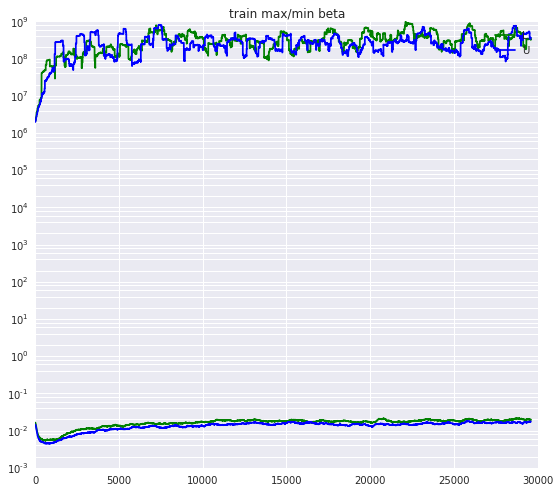

In [228]:
plt.figure(1,figsize=(9,8))
maxbetaL = moving_average(np.exp(train_logbetas['logbeta_L']).max(axis=1),n=500)
maxbetaU = moving_average(np.exp(train_logbetas['logbeta_U']).max(axis=1),n=500)
minbetaL = moving_average(np.exp(train_logbetas['logbeta_L']).min(axis=1),n=500)
minbetaU = moving_average(np.exp(train_logbetas['logbeta_U']).min(axis=1),n=500)
plt.plot(maxbetaL,label='L',color='g')
plt.plot(maxbetaU,label='U',color='b')
plt.plot(minbetaL,color='g')
plt.plot(minbetaU,color='b')
plt.legend()
plt.yscale('log')
#plt.ylim(0,1)
plt.title('train max/min beta')

In [ ]:
sortedL = np.sort(np.exp(train['logbeta_L']),axis=1)
for k in range(10):
    vals = reshape(sortedL)[:,:,k]
    plotPercentiles(vals,label='%s: %0.2f'%(k,vals[-1,:].mean()),alpha=0.05,linewidth=0.5)
plt.yscale('log')
plt.xlim(0,500)
#plt.ylim(1e-2,1e2)
plt.title('train beta L\n%s' % modelkey)
plt.legend()
plt.show()

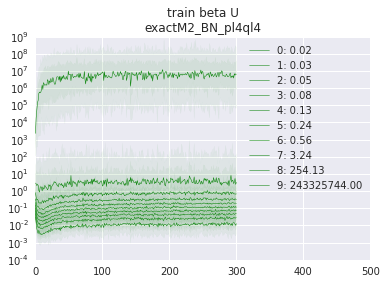

In [291]:
sortedU = np.sort(np.exp(train['logbeta_U']),axis=1)
for k in range(10):
    vals = reshape(sortedU)[:,:,k]
    plotPercentiles(vals,label='%s: %0.2f'%(k,vals[-1,:].mean()),color='g',alpha=0.05,linewidth=0.5)
plt.yscale('log')
plt.xlim(0,500)
#plt.ylim(1e-2,1e2)
plt.title('train beta U\n%s' % modelkey)
plt.legend()
plt.show()

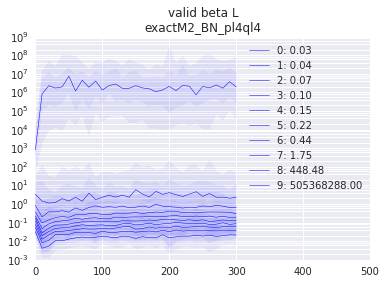

In [289]:
sortedL = np.sort(np.exp(valid['logbeta_L']),axis=1)
for k in range(10):
    vals = reshape(sortedL)[:,:,k]
    plotPercentiles(valid['epochs'],vals,label='%s: %0.2f'%(k,vals[-1,:].mean()),color='b',alpha=0.05,linewidth=0.5)
plt.yscale('log')
plt.xlim(0,500)
#plt.ylim(1e-2,1e2)
plt.title('valid beta L\n%s' % modelkey)
plt.legend()
plt.show()

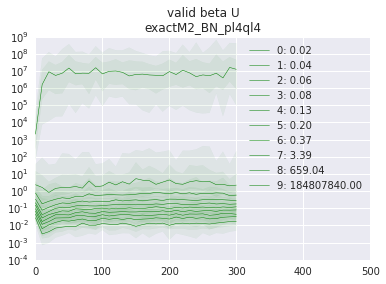

In [288]:
sortedU = np.sort(np.exp(valid['logbeta_U']),axis=1)
for k in range(10):
    vals = reshape(sortedU)[:,:,k]
    plotPercentiles(valid['epochs'],vals,label='%s: %0.2f'%(k,vals[-1,:].mean()),color='g',alpha=0.05,linewidth=0.5)
plt.yscale('log')
plt.xlim(0,500)
#plt.ylim(1e-2,1e2)
plt.title('valid beta U\n%s' % modelkey)
plt.legend()
plt.show()

## Params

In [263]:
params = results[modelkey]['params']
params.keys()

In [264]:
q_alpha_hx_b = params['q_alpha_h(x)_b']
q_alpha_hx_b.shape

In [265]:
plotPercentiles(q_alpha_hx_b)

In [266]:
q_alpha_hx_W = params['q_alpha_h(x)_W']
q_alpha_hx_W.shape

In [267]:
wTw = []
for epoch in range(q_alpha_hx_W.shape[0]):
    wTw_epoch = []
    for i in range(9):
        for j in range(i+1,10):
            wi = q_alpha_hx_W[epoch,i]
            wj = q_alpha_hx_W[epoch,j]
            wTw_epoch.append(np.dot(wi,wj)/np.linalg.norm(wi)/np.linalg.norm(wj))
    wTw.append(wTw_epoch)
wTw = np.array(wTw)
plotPercentiles(params['epochs'],np.abs(wTw))
plt.title('distribution of cosine similarities between vectors\nin q_alpha_h(x)_W\n%s' % modelkey)
plt.xlabel('epochs')
plt.ylabel('|cosine|')

## Z

In [268]:
muL = train['mu_L']
muU = train['mu_U']
print muU.shape

In [269]:
sorted_muL = muL[:,np.argsort(muL[-1])]
for i in range(muL.shape[1]):
    plt.plot(moving_average(sorted_muL[:,i],n=100),color='b',linewidth=0.1)

In [270]:
sorted_muU = muU[:,np.argsort(muU[-1])]
for i in range(muU.shape[1]):
    plt.plot(moving_average(sorted_muU[:,i],n=100),color='g',linewidth=0.1)

In [271]:
logcov2L = train['logcov2_L']
logcov2U = train['logcov2_U']
print logcov2U.shape
sigmaU = np.exp(0.5*logcov2U)
sigmaL = np.exp(0.5*logcov2L)

In [272]:
KL_U = 0.5*(np.exp(logcov2U)+muU**2.0-1.0-logcov2U)
KL_L = 0.5*(np.exp(logcov2L)+muL**2.0-1.0-logcov2L)

In [273]:
sorted_KL_U = np.sort(KL_U,axis=1)
for k in range(KL_U.shape[1]):
    vals = reshape(sorted_KL_U)[:,:,k]
    plotPercentiles(vals,color='g',alpha=0.05,linewidth=0.5)
#plt.xlim(0,500)
plt.ylim(0,9)
plt.title('KL(Z)_U')
plt.legend()
plt.show()

sorted_KL_L = np.sort(KL_L,axis=1)
for k in range(KL_L.shape[1]):
    vals = reshape(sorted_KL_L)[:,:,k]
    plotPercentiles(vals,color='b',alpha=0.05,linewidth=0.5)
#plt.xlim(0,500)
plt.ylim(0,9)
plt.title('KL(Z)_L')
plt.legend()
plt.show()


In [274]:
plt.figure(1,figsize=(16,6))

plt.subplot(1,2,1)
sorted_KL_U = KL_U[:,np.argsort(KL_U[-1])]
for i in range(KL_U.shape[1]):
    plt.plot(moving_average(sorted_KL_U[:,i],n=100),color='g',linewidth=0.5)
activeKL_U = np.sum(KL_U > 0.1,axis=1)
activeKL_U = moving_average(activeKL_U,n=100)
plt.plot(activeKL_U,color='k',label='# active KLs > 0.2')
plt.title('train KL(Z)_U')
plt.ylim(0,12)
plt.legend()

plt.subplot(1,2,2)
sorted_KL_L = KL_L[:,np.argsort(KL_L[-1])]
for i in range(KL_L.shape[1]):
    plt.plot(moving_average(sorted_KL_L[:,i],n=100),color='b',linewidth=0.5)
activeKL_L = np.sum(KL_L > 0.1,axis=1)
activeKL_L = moving_average(activeKL_L,n=100)
plt.plot(activeKL_L,color='k',label='# active KLs > 0.2')
plt.title('train KL(Z)_L')
plt.ylim(0,12)
plt.legend()

In [275]:
plt.figure(1,figsize=(16,6))

muL = valid['mu_L']
muU = valid['mu_U']
logcov2L = valid['logcov2_L']
logcov2U = valid['logcov2_U']
sigmaU = np.exp(0.5*logcov2U)
sigmaL = np.exp(0.5*logcov2L)
KL_U = 0.5*(np.exp(logcov2U)+muU**2.0-1.0-logcov2U)
KL_L = 0.5*(np.exp(logcov2L)+muL**2.0-1.0-logcov2L)

plt.subplot(1,2,1)
sorted_KL_U = KL_U[:,np.argsort(KL_U[-1])]
for i in range(KL_U.shape[1]):
    plt.plot(moving_average(sorted_KL_U[:,i],n=100),color='g',linewidth=0.5)
activeKL_U = np.sum(KL_U > 0.1,axis=1)
activeKL_U = moving_average(activeKL_U,n=10)
plt.plot(activeKL_U,color='k',label='# active KLs > 0.2')
plt.title('valid KL(Z)_U')
plt.ylim(0,12)
plt.legend()

plt.subplot(1,2,2)
sorted_KL_L = KL_L[:,np.argsort(KL_L[-1])]
for i in range(KL_L.shape[1]):
    plt.plot(moving_average(sorted_KL_L[:,i],n=100),color='b',linewidth=0.5)
activeKL_L = np.sum(KL_L > 0.1,axis=1)
activeKL_L = moving_average(activeKL_L,n=10)
plt.plot(activeKL_L,color='k',label='# active KLs > 0.2')
plt.title('valid KL(Z)_L')
plt.ylim(0,12)
plt.legend()